Goal:
Compare two separate facilities for each patient type to combined facilities for both types.

Generate arrival times for both types
Schedule for first possible slot using the recommended slot durations from part 1
    this is where the systems differ
Generate duration of appointment

KPIs:

Per type and total:

    Expected Wait time (time between call and scheduled slot)

    Unexpected wait time (time that patients have to wait on the same day due to appointments taking more time) 

    --> (Percentage patients with delay bigger than certain value x) DIEGO: Misschien is dit nog een goede? 
            - Misschien dan CDF van delay plotten. 
    

Overtime (Afhankelijk van hoe je je dag indeelt) 

    --> Max overtime per day (expected max overtime, confidence interval?)

Per facility and total: (Fraction, total, mean)

    Expected Idle Time / Availability (utilization used time/available time)
    Unexpected "

Patients served per day


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scipy.stats as stats

In [3]:
# Data from Part 1
df_base = pd.read_csv('des_params_summary.csv', index_col=0)

# Input parameters from Part 1
lbda_arrive_1 = df_base.loc['t1_lambda', 'estimate']
mu_serve_1 = df_base.loc['t1_duration_mean', 'estimate']
sd_serve_1 = df_base.loc['t1_duration_sd', 'estimate']
slot_length_1 = df_base.loc['t1_slot_hours', 'estimate']
slot_length_2 = df_base.loc['t2_slot_hours', 'estimate']

START_H = 8.0
END_H = 17.0
WORK_H = END_H - START_H

lbda_per_hour = lbda_arrive_1 / WORK_H

rng = np.random.default_rng(seed=42)


## Data inter-arrival times type 2 patients
Loads data of the original sample and creates a set with first arrival times and a set with interarrival times from which we can sample new values.

In [4]:
df = pd.read_csv("ScanRecords.csv")
d2 = df[df["PatientType"] == "Type 2"].copy()
d2["datetime"] = (
    pd.to_datetime(d2["Date"])
    + pd.to_timedelta(d2["Time"], unit="h")
)

d2 = d2.sort_values("datetime").reset_index(drop=True)

d2["day"] = d2["datetime"].dt.date

first_dt = d2.groupby("day")["datetime"].min() # First arrival time per day
day_start = pd.to_datetime(first_dt.index) + pd.to_timedelta(8, unit="h") 
ia_first_PerDay = ((first_dt - day_start).dt.total_seconds() / 3600).to_numpy() # Time of first arrival per day in hours since 8:00

d2["ia_between_min"] = (
    d2.groupby("day")["datetime"]
      .diff()
      .dt.total_seconds() / 3600
)

ia_between_PerDay = (
    d2["ia_between_min"]
    .dropna()
    .to_numpy()
) # Inter-arrival times between patients in hours


## Discrete event study

In [5]:
def gen_type_1_arrs_and_durs(lbda_arr, mu_ser, sd_ser, days, rng):
    for day in range(1, days+1):
        t = 0.0
        while True:
            ia = rng.exponential(scale=1.0 / lbda_arr)
            t += ia
            if t > WORK_H:
                break  
            dur = rng.normal(loc=mu_ser, scale=sd_ser)
            dur = max(dur, 0.01)  # Ensure duration is positive
            yield day, START_H + t, dur, 1

arrivals_1 = gen_type_1_arrs_and_durs(lbda_per_hour, mu_serve_1, sd_serve_1, 21, rng)
arrivals_1_df = pd.DataFrame(arrivals_1, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])
arrivals_1_df 

,day,call_arrival_time,service_duration,patient_type
0,1,9.276392,0.327381,1
1,1,10.542459,0.520028,1
2,1,10.588348,0.301878,1
3,1,11.336895,0.397779,1
4,1,11.378992,0.345565,1
...,...,...,...,...
357,21,14.160215,0.455595,1
358,21,14.176694,0.504193,1
359,21,14.235967,0.270976,1
360,21,14.765550,0.525979,1


In [6]:
def gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, durations, days, rng):
    for day in range(1, days + 1):
        t = 0.0
        while True:
            if t == 0.0:
                ia = rng.choice(ia_first_PerDay)
            else:
                ia = rng.choice(ia_between_PerDay)
            t += ia
            if t > WORK_H:
                break
            dur = rng.choice(durations)
            yield day, START_H + t, dur, 2

arrivals_2 = gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, d2["Duration"].to_numpy(), 21, rng)
arrivals_2_df = pd.DataFrame(arrivals_2, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])
arrivals_2_df


,day,call_arrival_time,service_duration,patient_type
0,1,8.39,0.756534,2
1,1,9.51,0.502129,2
2,1,10.16,0.536704,2
3,1,10.93,0.878381,2
4,1,12.05,0.769735,2
...,...,...,...,...
213,21,13.20,0.756534,2
214,21,14.38,0.367285,2
215,21,15.50,0.606150,2
216,21,16.09,0.807654,2


In [7]:
def combine_arrivals(arrivals_1_df, arrivals_2_df):
    combined_df = pd.concat([arrivals_1_df, arrivals_2_df], ignore_index=True)
    combined_df = combined_df.sort_values(by=['day', 'call_arrival_time']).reset_index(drop=True)
    cols_to_add = ['scheduled_day', 'scheduled_start', 'scheduled_end', 'actual_start', 'actual_end', 'machine_id']
    for col in cols_to_add:
        combined_df[col] = pd.NA
    # combined_df['patient_id'] = combined_df.index + 1
    return combined_df

combined_arrivals_df = combine_arrivals(arrivals_1_df, arrivals_2_df)
combined_arrivals_df

,day,call_arrival_time,service_duration,patient_type,scheduled_day,scheduled_start,scheduled_end,actual_start,actual_end,machine_id
0,1,8.390000,0.756534,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,9.276392,0.327381,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,1,9.510000,0.502129,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1,10.160000,0.536704,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1,10.542459,0.520028,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
575,21,14.765550,0.525979,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
576,21,15.500000,0.606150,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
577,21,15.778549,0.329264,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
578,21,16.090000,0.807654,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [8]:


def schedule_specialized(arrivals_df, slot_length_1, slot_length_2):
    arrivals_df = arrivals_df.copy()
    next_free = {1: {}, 2: {}}

    def get_next_free(machine, day):
        if day not in next_free[machine]:
            next_free[machine][day] = START_H
        return next_free[machine][day]

    for idx, row in arrivals_df.iterrows():
        machine_id = row['patient_type']
        arrivals_df.loc[idx, 'machine_id'] = machine_id
        slot_length = slot_length_1 if row['patient_type'] == 1 else slot_length_2

        # start searching from next working day
        try_day = row['day'] + 1

        while True:
            next_start = get_next_free(machine_id, try_day)

            # if it fits in the working day, schedule it
            if next_start + slot_length <= END_H:
                arrivals_df.loc[idx, 'scheduled_day'] = try_day
                arrivals_df.loc[idx, 'scheduled_start'] = next_start
                arrivals_df.loc[idx, 'scheduled_end'] = next_start + slot_length
                next_free[machine_id][try_day] = arrivals_df.loc[idx, 'scheduled_end']

                # determine actual start and end times
                # if scheduled start is at beginning of day, use arrival time
                if next_start == 8.0:
                    arrivals_df.loc[idx, 'actual_start'] = next_start
                    arrivals_df.loc[idx, 'actual_end'] = next_start + row['service_duration']
                
                else:
                    # find previous patient on same machine
                    i = 1
                    while True:
                        if arrivals_df.loc[idx - i, 'machine_id'] == machine_id:
                            break
                        i += 1

                    # if previous patient's end time is after scheduled start time, start after that
                    if arrivals_df.loc[idx-i, 'actual_end'] > next_start:
                        arrivals_df.loc[idx, 'actual_start'] = arrivals_df.loc[idx-i, 'actual_end']
                        arrivals_df.loc[idx, 'actual_end'] = arrivals_df.loc[idx-i, 'actual_end'] + row['service_duration']

                    # otherwise, use scheduled start time 
                    else:
                        arrivals_df.loc[idx, 'actual_start'] = next_start
                        arrivals_df.loc[idx, 'actual_end'] = next_start + row['service_duration']
                break

            # otherwise, try next day
            else:
                try_day += 1
                
    return arrivals_df


spec_df = schedule_specialized(combined_arrivals_df, slot_length_1, slot_length_2)
spec_df

,day,call_arrival_time,service_duration,patient_type,scheduled_day,scheduled_start,scheduled_end,actual_start,actual_end,machine_id
0,1,8.390000,0.756534,2,2,8.0,9.0,8.0,8.756534,2
1,1,9.276392,0.327381,1,2,8.0,8.583333,8.0,8.327381,1
2,1,9.510000,0.502129,2,2,9.0,10.0,9.0,9.502129,2
3,1,10.160000,0.536704,2,2,10.0,11.0,10.0,10.536704,2
4,1,10.542459,0.520028,1,2,8.583333,9.166667,8.583333,9.103361,1
...,...,...,...,...,...,...,...,...,...,...
575,21,14.765550,0.525979,1,26,8.0,8.583333,8.0,8.525979,1
576,21,15.500000,0.606150,2,25,16.0,17.0,16.0,16.60615,2
577,21,15.778549,0.329264,1,26,8.583333,9.166667,8.583333,8.912598,1
578,21,16.090000,0.807654,2,26,8.0,9.0,8.0,8.807654,2


In [9]:
def schedule_mixed(arrivals_df, slot_length_1, slot_length_2):
    arrivals_df = arrivals_df.copy()
    next_free = {1: {}, 2: {}}

    def get_next_free(machine, day):
        if day not in next_free[machine]:
            next_free[machine][day] = START_H
        return next_free[machine][day]

    for idx, row in arrivals_df.iterrows():
        slot_length = slot_length_1 if row['patient_type'] == 1 else slot_length_2

        # start searching from next working day
        try_day = row['day'] + 1

        while True:
            next_start_m1 = get_next_free(1, try_day)
            next_start_m2 = get_next_free(2, try_day)

            if next_start_m1 <= next_start_m2:
                machine_id, next_start = 1, next_start_m1
            else:
                machine_id, next_start = 2, next_start_m2

            # if it fits in the working day, schedule it
            if next_start + slot_length <= END_H:
                arrivals_df.loc[idx, 'scheduled_day'] = try_day
                arrivals_df.loc[idx, 'scheduled_start'] = next_start
                arrivals_df.loc[idx, 'scheduled_end'] = next_start + slot_length
                arrivals_df.loc[idx, 'machine_id'] = machine_id
                next_free[machine_id][try_day] = arrivals_df.loc[idx, 'scheduled_end']
                break

            # otherwise, try next day
            else:
                try_day += 1
        
        
    # Needed a second pass because type 1 patients could be scheduled before type 2 patients due to shorter slots
    # Don't need this for specialized scheduling since patients are scheduled in order of arrival per machine

    # Sort by scheduled day, machine, and start time
    scheduled_order = arrivals_df.sort_values(
        by=['scheduled_day', 'machine_id', 'scheduled_start']
    ).index

    # Track last actual_end per (day, machine)
    last_end = {}  # key: (scheduled_day, machine_id) -> actual_end

    for idx in scheduled_order:
        row = arrivals_df.loc[idx]
        day = row['scheduled_day']
        machine = row['machine_id']
        sched_start = row['scheduled_start']
        duration = row['service_duration']

        key = (day, machine)
        prev_end = last_end.get(key, START_H)

        # Actual start is the later of scheduled start or previous patient's end
        actual_start = max(sched_start, prev_end)
        actual_end = actual_start + duration

        arrivals_df.loc[idx, 'actual_start'] = actual_start
        arrivals_df.loc[idx, 'actual_end'] = actual_end

        last_end[key] = actual_end

    return arrivals_df

mix_df = schedule_mixed(combined_arrivals_df, slot_length_1, slot_length_2)
mix_df

,day,call_arrival_time,service_duration,patient_type,scheduled_day,scheduled_start,scheduled_end,actual_start,actual_end,machine_id
0,1,8.390000,0.756534,2,2,8.0,9.0,8.0,8.756534,1
1,1,9.276392,0.327381,1,2,8.0,8.583333,8.0,8.327381,2
2,1,9.510000,0.502129,2,2,8.583333,9.583333,8.583333,9.085462,2
3,1,10.160000,0.536704,2,2,9.0,10.0,9.0,9.536704,1
4,1,10.542459,0.520028,1,2,9.583333,10.166667,9.583333,10.103361,2
...,...,...,...,...,...,...,...,...,...,...
575,21,14.765550,0.525979,1,26,10.75,11.333333,10.75,11.275979,1
576,21,15.500000,0.606150,2,26,11.166667,12.166667,11.166667,11.772817,2
577,21,15.778549,0.329264,1,26,11.333333,11.916667,11.333333,11.662598,1
578,21,16.090000,0.807654,2,26,11.916667,12.916667,11.916667,12.724321,1


In [ ]:
def calc_kpis (schedule, sched_type=None, visualize=False):
    schedule = schedule.copy()

    # waiting time in working hours
    schedule['waiting_time_workh'] = (
        (schedule["scheduled_day"].astype(int) - schedule["day"].astype(int) - 1) * 9.0
        + (schedule["scheduled_start"].astype(float) - schedule["call_arrival_time"].astype(float))
    ) 
    # total waiting time in hours
    schedule['waiting_time_total'] = (
        (schedule["scheduled_day"].astype(int) - schedule["day"].astype(int)) * 24.0
        + (schedule["scheduled_start"].astype(float) - schedule["call_arrival_time"].astype(float))
    ) 

    # unexpected waiting time in hours
    schedule['unexpected_waiting_time'] = schedule['actual_start'] - schedule['scheduled_start']

    # waiting times in days
    schedule['waiting_time_days'] = schedule["scheduled_day"].astype(int) - schedule["day"].astype(int)

    # overtime in hours
    overtime = (schedule.groupby(['scheduled_day', 'machine_id'])['actual_end']
                .max()
                .apply(lambda x: max(0, x - END_H))
                .rename('overtime_h')
                .reset_index())
    
    # patients served per day
    patients_per_day = (schedule.groupby(['scheduled_day'])
                        .size()
                        .rename('patients_served_total')
                        .reset_index(drop=True))
    
    # utilization per machine per day
    utilization = (schedule.groupby(['scheduled_day', 'machine_id'])['service_duration']
                         .sum()
                         .apply(lambda x: x / WORK_H)
                         .rename('utilization')
                         .reset_index())
    
    # --- Visualizations ---
    if visualize:
            sns.histplot(schedule['waiting_time_days'], bins=range(0, schedule['waiting_time_days'].max()+2), kde=False)
            plt.title(f'Distribution of Waiting Times (Days) for {sched_type} scheduling')
            plt.xlabel('Waiting Time (Days)')
            plt.ylabel('Number of Patients')
            plt.savefig(f'{sched_type}_waiting_time_distribution.png')
            plt.clf()

            sns.lineplot(data=schedule, x='scheduled_day', y='waiting_time_days', errorbar='sd')
            plt.title(f'Average Waiting Time (Days) by Scheduled Day for {sched_type} scheduling')
            plt.xlabel('Scheduled Day') 
            plt.ylabel('Average Waiting Time (Days)')
            plt.savefig(f'{sched_type}_avg_waiting_time_by_day.png')
            plt.clf()

    # --- Summary Statistics ---
    summary = {}
    
    # 1. Waiting time (days) - patient perspective
    wt_days = schedule['waiting_time_days']
    summary['wait_days_mean'] = wt_days.mean()
    summary['wait_days_median'] = wt_days.median()
    summary['wait_days_std'] = wt_days.std()
    summary['wait_days_p90'] = wt_days.quantile(0.90)
    summary['wait_days_p95'] = wt_days.quantile(0.95)
    summary['wait_days_max'] = wt_days.max()
    summary['pct_wait_over_3days'] = (wt_days > 3).mean() * 100
    summary['pct_wait_over_7days'] = (wt_days > 7).mean() * 100
    
    # 2. Unexpected waiting time (same-day delays)
    uwt = schedule['unexpected_waiting_time']
    summary['unexpected_wait_mean'] = uwt.mean()
    summary['unexpected_wait_std'] = uwt.std()
    summary['unexpected_wait_p90'] = uwt.quantile(0.90)
    summary['unexpected_wait_max'] = uwt.max()
    summary['pct_patients_delayed'] = (uwt > 0.01).mean() * 100  # >0.6 min delay
    summary['pct_delay_over_15min'] = (uwt > 0.25).mean() * 100
    summary['pct_delay_over_30min'] = (uwt > 0.5).mean() * 100
    
    # 3. Overtime - staff/operations perspective
    ot = overtime['overtime_h']
    summary['overtime_mean'] = ot.mean()
    summary['overtime_total'] = ot.sum()
    summary['overtime_max'] = ot.max()
    summary['pct_days_with_overtime'] = (ot > 0).mean() * 100
    
    # 4. Utilization - efficiency perspective
    util = utilization['utilization']
    summary['utilization_mean'] = util.mean()
    summary['utilization_std'] = util.std()
    summary['utilization_min'] = util.min()
    summary['utilization_max'] = util.max()
    
    # 5. Throughput
    summary['patients_per_day_mean'] = patients_per_day.mean()
    summary['patients_per_day_std'] = patients_per_day.std()
    summary['total_patients'] = len(schedule)
    
    # By patient type
    for ptype in [1, 2]:
        subset = schedule[schedule['patient_type'] == ptype]
        summary[f'type{ptype}_wait_days_mean'] = subset['waiting_time_days'].mean()
        summary[f'type{ptype}_wait_days_p90'] = subset['waiting_time_days'].quantile(0.90)
        summary[f'type{ptype}_unexpected_wait_mean'] = subset['unexpected_waiting_time'].mean()
    
    return pd.Series(summary)

kpi_mix = calc_kpis(mix_df, sched_type="mixed", visualize=True)
kpi_spec = calc_kpis(spec_df, sched_type="specialized", visualize=True)
pd.concat([kpi_mix, kpi_spec], axis=1, keys=['Mixed Scheduling', 'Specialized Scheduling'])

,Mixed Scheduling,Specialized Scheduling
wait_days_mean,2.872414,2.634483
wait_days_median,3.000000,3.000000
wait_days_std,1.023522,0.935308
wait_days_p90,4.000000,4.000000
wait_days_p95,4.000000,4.000000
wait_days_max,5.000000,5.000000
pct_wait_over_3days,28.620690,16.896552
pct_wait_over_7days,0.000000,0.000000
unexpected_wait_mean,0.003362,0.002357
unexpected_wait_std,0.018951,0.014978


<Figure size 640x480 with 0 Axes>

## Bootstrap DES integration

In [ ]:
df_boot = pd.read_csv('des_bootstrap_params.csv', index_col=0)
df_params = df_boot[['t1_lambda', 't1_duration_mean', 't1_duration_sd']].rename(
    columns={
        't1_lambda': 'lbda_arrive',
        't1_duration_mean': 'mu_serve',
        't1_duration_sd': 'sd_serve'
    }
)
df_params['lbda_arrive'] = df_params['lbda_arrive'] / WORK_H  # per hour

def run_sim(row, ia_first_PerDay, ia_between_PerDay, dur2, days, slot_length_1, slot_length_2, rng):
    arrivals_1 = gen_type_1_arrs_and_durs(row.lbda_arrive, row.mu_serve, row.sd_serve, days, rng)
    arrivals_1_df = pd.DataFrame(arrivals_1, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])

    arrivals_2 = gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, dur2, days, rng)
    arrivals_2_df = pd.DataFrame(arrivals_2, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])

    combined_arrivals_df = combine_arrivals(arrivals_1_df, arrivals_2_df)

    mix_df = schedule_mixed(combined_arrivals_df, slot_length_1, slot_length_2)
    spec_df = schedule_specialized(combined_arrivals_df, slot_length_1, slot_length_2)

    kpi_mix = calc_kpis(mix_df, visualize=False)
    kpi_spec = calc_kpis(spec_df, visualize=False)

    return kpi_mix, kpi_spec

# Run in parallel
dur2 = d2["Duration"].to_numpy()
results = Parallel(n_jobs=-1)(
    delayed(run_sim)(
        row, ia_first_PerDay, ia_between_PerDay, dur2, 21, 
        slot_length_1, slot_length_2, rng
    )
    for i, row in enumerate(df_params.head(1000).itertuples())
) # run all parameter sets in parallel

kpi_mix_list, kpi_spec_list = zip(*results)
kpi_mix_df = pd.DataFrame(kpi_mix_list)
kpi_spec_df = pd.DataFrame(kpi_spec_list)


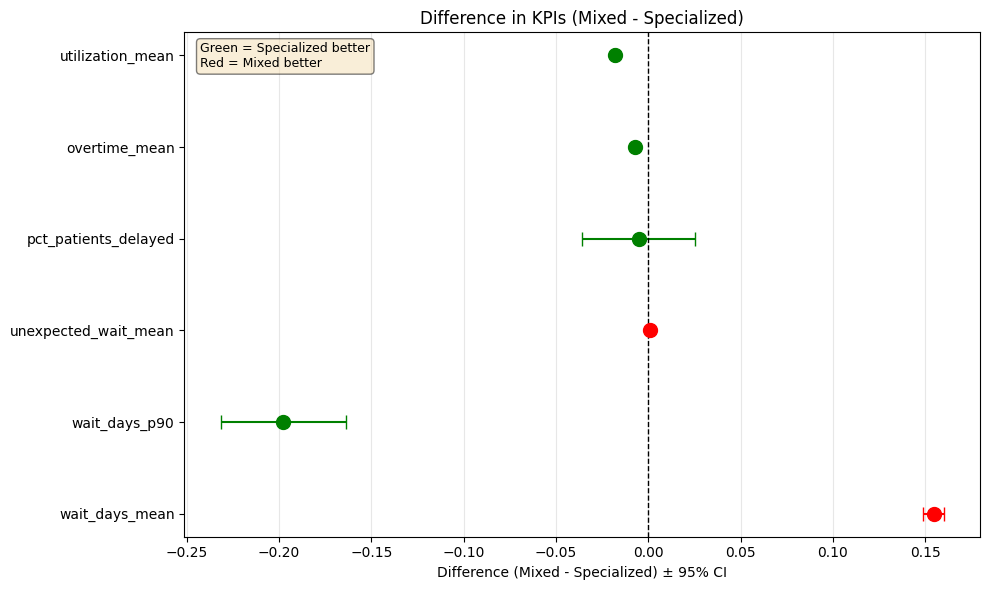

In [ ]:
def calc_ci(data, confidence=0.95):
    """Calculate mean and confidence interval."""
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    ci = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, ci

def prepare_comparison_data(kpi_mix_df, kpi_spec_df, kpis_to_compare):
    """Prepare data for plotting."""
    rows = []
    for kpi in kpis_to_compare:
        mix_mean, mix_ci = calc_ci(kpi_mix_df[kpi])
        spec_mean, spec_ci = calc_ci(kpi_spec_df[kpi])
        
        rows.append({
            'KPI': kpi,
            'Scheduling': 'Mixed',
            'Mean': mix_mean,
            'CI': mix_ci
        })
        rows.append({
            'KPI': kpi,
            'Scheduling': 'Specialized',
            'Mean': spec_mean,
            'CI': spec_ci
        })
    
    return pd.DataFrame(rows)

# Define key KPIs to compare (group by category)
wait_kpis = ['wait_days_mean', 'wait_days_p90', 'wait_days_max']
delay_kpis = ['unexpected_wait_mean', 'unexpected_wait_p90', 'pct_patients_delayed']
operations_kpis = ['overtime_mean', 'overtime_max', 'utilization_mean']

all_kpis = ['wait_days_mean', 'wait_days_p90', 'unexpected_wait_mean', 
            'pct_patients_delayed', 'overtime_mean', 'utilization_mean']


def plot_difference(kpi_mix_df, kpi_spec_df, kpis, title, figsize=(10, 6)):
    """Plot the difference (Mixed - Specialized) with CI."""
    fig, ax = plt.subplots(figsize=figsize)
    
    y_positions = np.arange(len(kpis))
    
    for i, kpi in enumerate(kpis):
        # Calculate difference for each simulation
        diff = kpi_mix_df[kpi].values - kpi_spec_df[kpi].values
        diff_mean, diff_ci = calc_ci(diff)
        
        # Color based on sign
        color = 'red' if diff_mean > 0 else 'green'
        
        ax.errorbar(diff_mean, i, xerr=diff_ci, fmt='o',
                    color=color, capsize=5, markersize=10)
    
    # Add vertical line at zero
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(kpis)
    ax.set_xlabel('Difference (Mixed - Specialized) ± 95% CI')
    ax.set_title(title)
    
    # Add annotation
    ax.text(0.02, 0.98, 'Green = Specialized better\nRed = Mixed better', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    return fig, ax

fig, ax = plot_difference(kpi_mix_df, kpi_spec_df, all_kpis,
                          'Difference in KPIs (Mixed - Specialized)')
plt.savefig('difference_plot.png', dpi=150)

In [33]:
# =============================================================================
# Summary table with statistical tests
# =============================================================================
def create_summary_table(kpi_mix_df, kpi_spec_df, kpis):
    rows = []
    for kpi in kpis:
        mix_mean, mix_ci = calc_ci(kpi_mix_df[kpi])
        spec_mean, spec_ci = calc_ci(kpi_spec_df[kpi])
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(kpi_mix_df[kpi], kpi_spec_df[kpi])
        
        rows.append({
            'KPI': kpi,
            'Mixed Mean': f'{mix_mean:.3f}',
            'Mixed 95% CI': f'±{mix_ci:.3f}',
            'Specialized Mean': f'{spec_mean:.3f}',
            'Specialized 95% CI': f'±{spec_ci:.3f}',
            'Difference': f'{mix_mean - spec_mean:.3f}',
            'p-value': f'{p_value:.4f}',
            'Significant': '✓' if p_value < 0.05 else ''
        })
    
    return pd.DataFrame(rows)

summary_table = create_summary_table(kpi_mix_df, kpi_spec_df, all_kpis)
print(summary_table.to_string(index=False))

# Save to CSV
summary_table.to_csv('kpi_comparison_summary.csv', index=False)

                 KPI Mixed Mean Mixed 95% CI Specialized Mean Specialized 95% CI Difference p-value Significant
      wait_days_mean      2.314       ±0.021            2.160             ±0.023      0.155  0.0000           ✓
       wait_days_p90      2.949       ±0.034            3.147             ±0.043     -0.198  0.0000           ✓
unexpected_wait_mean      0.006       ±0.000            0.005             ±0.000      0.001  0.0000           ✓
pct_patients_delayed      5.158       ±0.046            5.163             ±0.039     -0.005  0.7362            
       overtime_mean      0.000       ±0.000            0.008             ±0.000     -0.007  0.0000           ✓
    utilization_mean      0.663       ±0.001            0.681             ±0.001     -0.018  0.0000           ✓
